# First simple web-map with Folium


**Date**: 22.03.2023

**Course**: Methods of Spatial Analysis. Advanced Level. // HSE, Moscow, spring 2023


## 1. Import libraries


In [33]:
## For working with dataframes

import pandas as pd
import geopandas as gpd
import folium
import matplotlib
import mapclassify

from shapely import geometry


## 2.Read data from a geojson file


нужен слой с полигонами!

In [147]:
data = gpd.read_file('./okn_points.geojson')
#data_poly = gpd.read_file('./okn_poly.geojson')
data.head()

,field_1,V1,Объект,Номер в реестре,название улицы,Комментарий,Идентификатор дома в ФИАС,FiasAuxSubobjId,FiasAuxObjId,Идентификатор улицы в ФИАС,...,категория объекта,дата создания объекта,дата обновления объекта,address,lat,lon,raw,longitude,latitude,geometry
0,107,107,Братская могила советских летчиков,761410306510005,NA,NA,NA,NA,NA,NA,...,heritage,2015-10-15 15:30:09,NA,"Ярославская область, город Рыбинск, ул. Балоба...",58.10542,38.65757,"{coordinates:[38.6597925196503,58.106236472424...",38.6597925196503,58.1062364724241,POINT (38.65757 58.10542)
1,192,192,"Дом (деревянный), в котором жил физиолог А.А.У...",761410049750005,NA,NA,NA,NA,NA,NA,...,heritage,NA,2021-12-23 10:51:50,"Ярославская область, г. Рыбинск, ул. Ухтомског...",58.03793,38.86643,"{coordinates:[38.8664276441802,58.037922225234...",38.8664276441802,58.0379222252347,POINT (38.86643 58.03793)
2,287,287,Церковь Казанская,761410097470006,NA,NA,NA,NA,NA,NA,...,heritage,NA,2021-12-23 10:15:14,"Ярославская область, г. Рыбинск, ул. Большая К...",58.04455,38.86899,"{coordinates:[38.868961,58.044601],type:Point}",38.868961,58.044601,POINT (38.86899 58.04455)
3,288,288,Здание Старой Биржи,761410097970006,NA,NA,NA,NA,NA,NA,...,heritage,NA,2021-12-23 10:16:11,"Ярославская область, город Рыбинск, Волжская н...",58.04975,38.85486,"{coordinates:[38.854759,58.049736],type:Point}",38.854759,58.049736,POINT (38.85486 58.04975)
4,297,297,"Дом, в котором учился Щербаков Александр Серге...",761410109950006,NA,NA,NA,NA,NA,NA,...,heritage,NA,2021-12-23 16:41:20,"Ярославская область, г. Рыбинск, ул. Крестовая...",58.04818,38.85637,"{coordinates:[38.8563055509261,58.048178909621...",38.8563055509261,58.0481789096211,POINT (38.85637 58.04818)


#### \* clear data and save only valuable attributes

(here is an example how to drop fields, you may need to delete more/less depends, you may choose another way to remove attributes )


In [148]:
data = data.drop(columns=['Тип объекта культурного наследия', 'текстовое описание границ' ])

## 2.Create Grid (fishnet)

- to plot concentration of cultural heritage (or any other point layer) with a choropleth map


#### 2.1. Check CRS of current data and decide do you need to reproject it or not?


- here is an example of reading the current crs and reprojecting geodataframe to another crs (you need to choose by yourself do you need it or not), but I'd rather reccommend to use UTM-zone, when you plot data with folium it is better to choose Web Mercator (EPSG:3857)


In [149]:
data = data.to_crs("EPSG:32637")
print(data.crs.name)

WGS 84 / UTM zone 37N


#### 2.2. Get the extent of the data


In [150]:
total_bounds = data.total_bounds
minX, minY, maxX, maxY = total_bounds

#### 2.3. Select cell-size


- what are the units?


In [152]:
square_size = 500

#### 2.4. Create fishnet


- you may choose another way to create using QGIS and read prepared data here


In [153]:
grid_cells = []
x, y = (minX, minY)
geom_array = []

while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size


fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:32637')
fishnet['id'] = fishnet.index

In [154]:
fishnet.head()

,geometry,id
0,"POLYGON ((479818.808 6432880.065, 479818.808 6...",0
1,"POLYGON ((480318.808 6432880.065, 480318.808 6...",1
2,"POLYGON ((480818.808 6432880.065, 480818.808 6...",2
3,"POLYGON ((481318.808 6432880.065, 481318.808 6...",3
4,"POLYGON ((481818.808 6432880.065, 481818.808 6...",4


- save final grid to file if you need it


In [122]:
#fishnet.to_file('grid.gpkg')

## 3. Count Points in Polygon


#### 3.1. Merge fishnet and your points data to count them in polygons


In [155]:
data.explore()

In [124]:
#fishnet.explore()

In [156]:
merged = gpd.sjoin(data, fishnet, how='left', predicate='within')

In [157]:
merged

,field_1,V1,Объект,Номер в реестре,название улицы,Комментарий,Идентификатор дома в ФИАС,FiasAuxSubobjId,FiasAuxObjId,Идентификатор улицы в ФИАС,...,дата обновления объекта,address,lat,lon,raw,longitude,latitude,geometry,index_right,id
0,107,107,Братская могила советских летчиков,761410306510005,NA,NA,NA,NA,NA,NA,...,NA,"Ярославская область, город Рыбинск, ул. Балоба...",58.10542,38.65757,"{coordinates:[38.6597925196503,58.106236472424...",38.6597925196503,58.1062364724241,POINT (479818.808 6440498.194),NaN,NaN
1,192,192,"Дом (деревянный), в котором жил физиолог А.А.У...",761410049750005,NA,NA,NA,NA,NA,NA,...,2021-12-23 10:51:50,"Ярославская область, г. Рыбинск, ул. Ухтомског...",58.03793,38.86643,"{coordinates:[38.8664276441802,58.037922225234...",38.8664276441802,58.0379222252347,POINT (492113.136 6432940.835),24.0,24.0
2,287,287,Церковь Казанская,761410097470006,NA,NA,NA,NA,NA,NA,...,2021-12-23 10:15:14,"Ярославская область, г. Рыбинск, ул. Большая К...",58.04455,38.86899,"{coordinates:[38.868961,58.044601],type:Point}",38.868961,58.044601,POINT (492265.726 6433677.568),49.0,49.0
3,288,288,Здание Старой Биржи,761410097970006,NA,NA,NA,NA,NA,NA,...,2021-12-23 10:16:11,"Ярославская область, город Рыбинск, Волжская н...",58.04975,38.85486,"{coordinates:[38.854759,58.049736],type:Point}",38.854759,58.049736,POINT (491432.795 6434258.210),73.0,73.0
4,297,297,"Дом, в котором учился Щербаков Александр Серге...",761410109950006,NA,NA,NA,NA,NA,NA,...,2021-12-23 16:41:20,"Ярославская область, г. Рыбинск, ул. Крестовая...",58.04818,38.85637,"{coordinates:[38.8563055509261,58.048178909621...",38.8563055509261,58.0481789096211,POINT (491521.555 6434083.225),73.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1024,1025,Дом доходный Журавлёвых,762111338500004,NA,NA,NA,NA,NA,NA,...,NA,"Ярославская область, г. Рыбинск, ул. Стоялая, ...",58.04796,38.85219,None,NA,NA,POINT (491274.757 6434059.264),72.0,72.0
76,1048,1050,Дом Связи,762111355270004,NA,NA,NA,NA,NA,NA,...,NA,"Ярославская область, г. Рыбинск, ул. Пушкина, ...",58.04646,38.83914,None,NA,NA,POINT (490504.017 6433894.024),71.0,71.0
77,1049,1051,Дом доходный Крашенинниковых - А.А. Седова,762111348990004,NA,NA,NA,NA,NA,NA,...,NA,"Ярославская область, г. Рыбинск, ул. Крестовая...",58.04834,38.85560,None,NA,NA,POINT (491476.140 6434101.135),73.0,73.0
78,1065,1067,Церковь во имя святого благоверного князя Алек...,762111357860004,NA,NA,NA,NA,NA,NA,...,NA,"Ярославская область, Рыбинский район, дер. Мак...",58.06703,38.73381,None,NA,NA,POINT (484295.158 6436203.817),158.0,158.0


In [158]:
merged['n'] = 1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
fishnet.loc[dissolve.index, 'n'] = dissolve.n.values

In [159]:
fishnet

,geometry,id,n
0,"POLYGON ((479818.808 6432880.065, 479818.808 6...",0,NaN
1,"POLYGON ((480318.808 6432880.065, 480318.808 6...",1,NaN
2,"POLYGON ((480818.808 6432880.065, 480818.808 6...",2,NaN
3,"POLYGON ((481318.808 6432880.065, 481318.808 6...",3,NaN
4,"POLYGON ((481818.808 6432880.065, 481818.808 6...",4,NaN
...,...,...,...
395,"POLYGON ((489818.808 6440380.065, 489818.808 6...",395,NaN
396,"POLYGON ((490318.808 6440380.065, 490318.808 6...",396,NaN
397,"POLYGON ((490818.808 6440380.065, 490818.808 6...",397,NaN
398,"POLYGON ((491318.808 6440380.065, 491318.808 6...",398,NaN


In [160]:
fishnet.explore()

#### 3.2. Plot the result


- we do it just to check the final result, no any other practical need


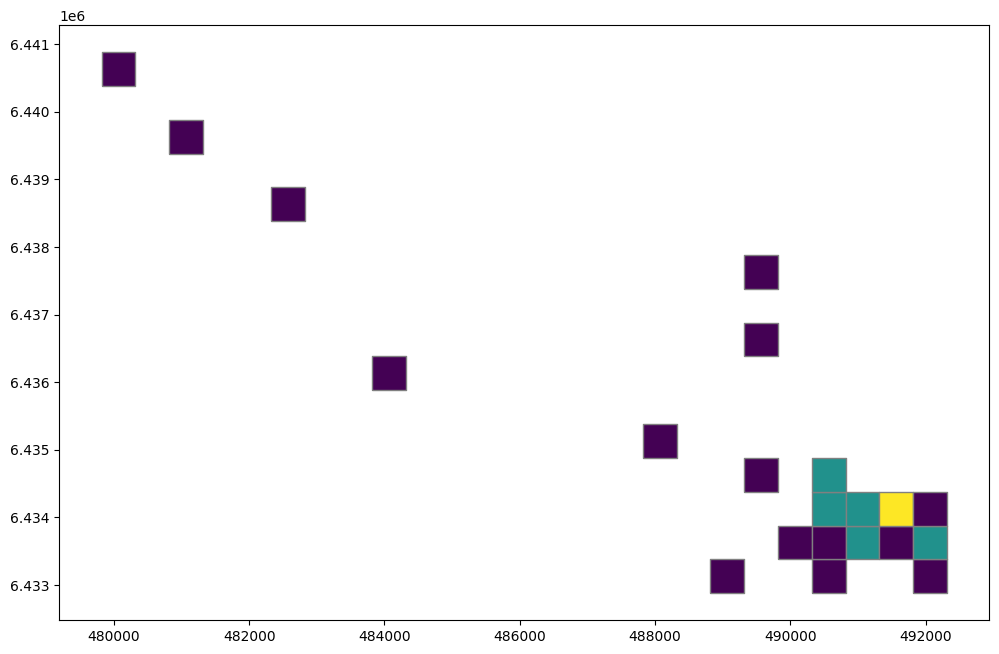

In [161]:
ax = fishnet.plot(column='n', figsize=(12, 8), cmap='viridis', scheme='natural_breaks', k=3, edgecolor="grey")


## 3. Create Web-map


#### 3.1 Map Settings

- carefully look at the function, try to understand what each variable stands for


In [162]:
data = data.to_crs('EPSG:4326')
m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=11,  tiles="cartodb positron", control_scale=True)


/var/folders/q_/9dtvr8qs5471dpn7wy0jc0s80000gn/T/ipykernel_1821/1229596728.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=11,  tiles="cartodb positron", control_scale=True)


#### 3.2 Explore the map box. Do we need any changes?


In [163]:
m

#### 3.3 Create a Choropleth map based on a fishnet


In [117]:
folium.Choropleth(
    geo_data=fishnet,
    data=fishnet,
    columns=['id', 'n'],
    fill_color='YlGnBu',
    fill_opacity = 0.5,
    key_on='id',
    nan_fill_opacity=0,
   line_color = "#0000",
   legend_name="amount of heritage sites",
   name='Heritage Sites Concentration'
).add_to(m)

- look a the map


In [118]:
m

здесь перестало отображаться то, что нужно

#### 3.4 Add heritage buildings with tooltips


для дальнейшего нужен слой с полигонами

- try to color heritage buildings based on their conservation status


In [167]:
#colors = ["orange", "yellow", "green", "blue"]
#categories = data_poly['Категория историко-культурного значения'].unique()

folium.GeoJson(
#   data_poly,
    name="Heritage buildings",
    tooltip=folium.GeoJsonTooltip(fields=["r_name"]),
    popup=folium.GeoJsonPopup(fields=['r_name']),
    style_function=lambda x: {
        "fillColor": 'yellow'
    },
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=True,
    show=False,
).add_to(m)


- look a the map


In [168]:
m

AssertionError: The field r_name is not available in the data. Choose from: ('field_1', 'V1', 'Объект', 'Номер в реестре', 'название улицы', 'Комментарий', 'Идентификатор дома в ФИАС', 'FiasAuxSubobjId', 'FiasAuxObjId', 'Идентификатор улицы в ФИАС', 'Идентификатор населенного пункта в ФИАС', 'Идентификатор внутрегородской территории в ФИАС', 'Идентификатор города в ФИАС', 'Идентификатор городских и сельских поселений в ФИАС', 'Идентификатор района в ФИАС', 'Идентификатор автономного округа в ФИАС', 'Идентификатор региона в ФИАС', 'Идентификатор страны в ФИАС', 'Полный адрес', 'На карте', 'Id-Регион', 'Регион', 'учетный номер', 'Id-Категория историко-культурного значения', 'Категория историко-культурного значения', 'Id-Тип объекта культурного наследия', 'Id-Вид объекта', 'Вид объекта', 'описание предмета охраны', 'Id-общая видовая принадлежность', 'Id-Принадлежность к Юнеско', 'Принадлежность к Юнеско', 'Id-Особо ценный объект', 'Особо ценный объект', 'идентификатор ансамбля', 'дата создания', 'GeoId', 'X', 'Y', 'наименование документа', 'Изображение', 'зоны охраны и режимы использования земель', 'Items', 'Id - идентификатор', 'признак актуальности', 'признак публичности', 'год постановки ОКН на Госохрану', 'год проведения реставрации', 'параметры, идентифицирующие ФЦП', 'относительный URL объекта', 'категория объекта', 'дата создания объекта', 'дата обновления объекта', 'address', 'lat', 'lon', 'raw', 'longitude', 'latitude').

#### 3.5 Add points cluster


In [14]:
from folium.plugins import MarkerCluster

In [27]:
marker_cluster = MarkerCluster(name='Heritage Sites')
mc1= folium.plugins.FeatureGroupSubGroup(marker_cluster, 'Heritage Sites')
m.add_child(marker_cluster)
m.add_child(mc1)
mc1.add_child(folium.GeoJson(data.to_json(), embed=False, show=False))


In [ ]:
m

#### 3.6 Add different widgets to map


- import plugins


In [28]:
from folium.plugins import MousePosition
from folium.plugins import Fullscreen

In [29]:
folium.LayerControl().add_to(m)

In [30]:
MousePosition().add_to(m)
Fullscreen(
    position="bottomright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(m)


In [ ]:
m

## 4. Save map to index.html file and prepare to publish it


In [ ]:
m.save("index.html")